In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import matplotlib as mpl
import numpy as np

spots_directory = Path(r"D:\Tracking\DrosophilaNucleusTracking\data\spots")
save_path = Path(r"D:\Tracking\DrosophilaNucleusTracking\figures\output")

rc = {
    # "figure.facecolor": "#FFFFFF00",
    # "axes.facecolor": "#FFFFFF00",
    "legend.framealpha": 0.2,
    "lines.color": "k",
    "svg.fonttype": "none",
}

sns.set_context("paper")
sns.set_theme(style="ticks", font="Arial", rc=rc)

print(mpl.font_manager.get_font_names())

['Franklin Gothic Book', 'Javanese Text', 'Eras Light ITC', 'Maiandra GD', 'Century Schoolbook', 'STIXSizeThreeSym', 'French Script MT', 'Felix Titling', 'Engravers MT', 'Mongolian Baiti', 'Cooper Black', 'Tahoma', 'Rockwell Extra Bold', 'Onyx', 'Microsoft Tai Le', 'Gill Sans MT', 'Gill Sans MT Ext Condensed Bold', 'Trebuchet MS', 'Freestyle Script', 'Ink Free', 'Script MT Bold', 'DejaVu Sans Mono', 'Snap ITC', 'Candara', 'Bradley Hand ITC', 'cmr10', 'Bookman Old Style', 'Arial', 'MS Reference Sans Serif', 'Parchment', 'Vladimir Script', 'Californian FB', 'Rage Italic', 'MV Boli', 'Old English Text MT', 'Bahnschrift', 'Leelawadee', 'Microsoft Himalaya', 'Segoe MDL2 Assets', 'Segoe Print', 'Calibri', 'Lato Black', 'Gill Sans Ultra Bold Condensed', 'Viner Hand ITC', 'Microsoft Sans Serif', 'Algerian', 'Book Antiqua', 'Chiller', 'Sylfaen', 'Eras Bold ITC', 'STIXGeneral', 'Segoe UI', 'Franklin Gothic Demi', 'Courier New', 'cmss10', 'Lucida Sans', 'Century Gothic', 'STIXNonUnicode', 'Magnet

In [14]:
spots_dfs = []

for i, spots_path in tqdm(enumerate(spots_directory.glob("*_spots.csv")), desc="reading spots dfs"):
    spots_df = pd.read_csv(spots_path)

    spots_df["source"] = i

    spots_dfs.append(spots_df)

reading spots dfs: 11it [00:27,  2.48s/it]


In [15]:
all_spots = pd.concat(spots_dfs, ignore_index=True)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

12_wt vs. 12_trk: t-test independent samples, P_val:5.468e-01 t=-6.260e-01
11_wt vs. 11_trk: t-test independent samples, P_val:1.868e-01 t=1.429e+00
13_wt vs. 13_trk: t-test independent samples, P_val:9.127e-02 t=-1.890e+00


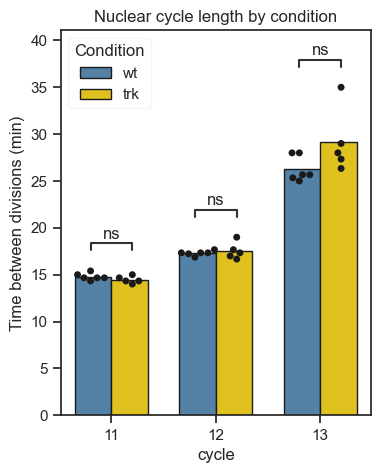

In [16]:
### plot nuclear cycle lengths
from statannotations.Annotator import Annotator

tracklets = all_spots.groupby(["source", "cycle", "tracklet_id"])

var_lengths = tracklets["time"].max() - tracklets["time"].min()
# var_lengths = tracklets["time"].count()
avg = var_lengths.groupby(["source", "cycle"]).median()
trk = all_spots.groupby(["source", "cycle"])["trk"].first()
condition = trk.map({True: "trk", False: "wt"})

stacked = pd.concat([avg, trk], axis=1).reset_index()
stacked["Condition"] = condition.values
subset = stacked[stacked["cycle"].isin([11, 12, 13])].copy()
# subset = stacked.copy()

fig, ax = plt.subplots(1,1, figsize=(4, 5))

x = "cycle"
y = "time"
hue = "Condition"
hue_order = ["wt", "trk"]

pal = ["cadetblue", "burlywood"]
pal = ["fuchsia", "magenta"]
pal = ["steelblue", "gold"]

sns.barplot(data=subset, x=x, y=y, hue=hue, palette=pal, hue_order=hue_order, ax=ax, width=0.7, errorbar=None, edgecolor="k")
sns.swarmplot(data=subset, x=x, y=y, hue=hue, palette=["k", "k"], order=[11, 12, 13], dodge=True, hue_order=hue_order, ax=ax, legend=False)

pairs = [((cycle, "trk"), (cycle, "wt")) for cycle in [ 11, 12, 13]]

annot = Annotator(None, pairs)
annot.new_plot(ax, pairs, plot='boxplot',
           data=subset, x=x, y=y, hue=hue, hue_order=hue_order)
annot.configure(test='t-test_ind', text_format='star', loc='inside', verbose=1)
annot.apply_test().annotate()

plt.ylabel(f"Time between divisions (min)")
plt.xlabel("cycle")
# ax.legend(title="")
plt.title(f"Nuclear cycle length by condition")
plt.savefig(save_path / f"time_between_divisions.svg", dpi=300)
plt.show()

In [30]:
from collections import defaultdict

wave_fronts = defaultdict(list)

for cycle in [11, 12, 13]:

    for i, df in enumerate(spots_dfs):

        t = df[df["cycle"] == cycle].groupby("tracklet_id")

        x = pd.cut(np.clip(t["AP"].last(), 0, 1), 40)
        x = np.array(x.apply(lambda v: (v.left + v.right) / 2))
        y = np.array(t["time"].max())

        y = y - np.mean(y)

        bg = t["time"].max().groupby(x, observed=True).mean()

        a_half = bg[bg.index < 0.5]
        mean_a = a_half.index[a_half.argmin()]
        p_half = bg[(bg.index > 0.5) * (bg.index < 0.95) ]
        mean_p = p_half.index[p_half.argmin()]

        wave_fronts["condition"].append("Trk-null" if df["trk"].min() else "Wild Type")
        wave_fronts["cycle"].append(cycle)
        wave_fronts["anterior"].append(mean_a)
        wave_fronts["posterior"].append(1 - mean_p)
        wave_fronts["wave_magnitude"].append(np.mean(np.abs(y)))

        cycle_length = np.array(t["time"].max()) - np.array(t["time"].mean())

        wave_fronts["length_magnitude"].append(np.mean(np.abs(cycle_length - cycle_length.mean())))


wave_fronts = pd.DataFrame(wave_fronts)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

12_Wild Type vs. 12_Trk-null: t-test independent samples, P_val:4.977e-01 t=7.066e-01
13_Wild Type vs. 13_Trk-null: t-test independent samples, P_val:5.193e-01 t=6.707e-01


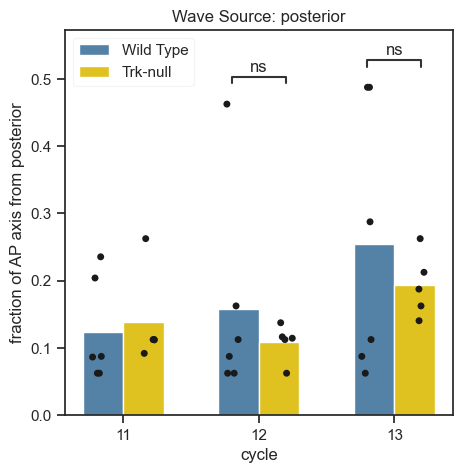

In [31]:
from statannotations.Annotator import Annotator

fig, ax = plt.subplots(1,1, figsize=(5, 5))

x = "cycle"
y = "posterior"
hue = "condition"
hue_order = ["Wild Type", "Trk-null"]

sns.barplot(data=wave_fronts, x=x, y=y, hue=hue, palette=pal, hue_order=hue_order, ax=ax, width=0.6, errorbar=None)
sns.stripplot(data=wave_fronts, x=x, y=y, hue=hue, palette=["k", "k"], order=[11, 12, 13], dodge=True, hue_order=hue_order, ax=ax, legend=False)

pairs = [((cycle, "Wild Type"), (cycle, "Trk-null")) for cycle in [12, 13]]

annot = Annotator(None, pairs)
annot.new_plot(ax, pairs, plot='boxplot',
           data=wave_fronts, x=x, y=y, hue=hue, hue_order=hue_order)
annot.configure(test='t-test_ind', text_format='star', loc='inside', verbose=1)
annot.apply_test().annotate()

plt.ylabel(f"fraction of AP axis from {y}")
plt.xlabel("cycle")
ax.legend(title="")
plt.title(f"Wave Source: {y}")
plt.savefig(save_path / f"wave_source_{y}.png", dpi=300)
plt.show()

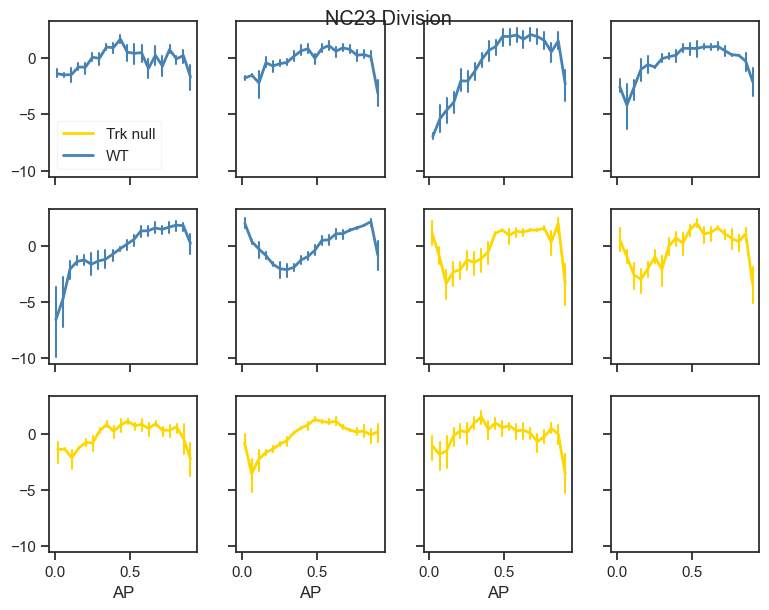

In [33]:
from matplotlib.lines import Line2D

fig, axes = plt.subplots(3, 4, figsize=(8, 6), sharex=True, sharey=True)
cycle = 13

plt.tight_layout()


for i, (df, ax) in enumerate(zip(spots_dfs, axes.flatten())):

    trk = df["trk"].min()

    color = pal[int(trk)]

    df = df[df["AP"] < 0.93]

    t = df[df["cycle"] == cycle].groupby("tracklet_id")

    x = pd.cut(t["AP"].last(), 20)
    x = x.apply(lambda v: (v.left + v.right) / 2)
    y = np.array(t["time"].max())

    y = y - np.mean(y)

    sns.lineplot(x=x, y=y, ax=ax, errorbar="ci", err_style="bars", color=color, lw=2)


custom_lines = [Line2D([0], [0], color=pal[1], lw=2),
                Line2D([0], [0], color=pal[0], lw=2)]

axes.flatten()[0].legend(custom_lines, ["Trk null", "WT"])

plt.savefig(save_path / f"ap_division_cycle_{cycle + 10}_line.png", dpi=300)
plt.suptitle(f"NC{cycle + 10} Division")

plt.show()